<a href="https://www.kaggle.com/code/andrey36912/notebook7313cda609?scriptVersionId=191777518" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [67]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [68]:
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder
import torch  
from sklearn.model_selection import train_test_split
!pip install torchsummary

import torch.nn as nn  
from torch.utils.data import Dataset, DataLoader
from torch import nn
import torch.nn.functional as F
from torchsummary import summary
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

df = pd.read_csv('https://raw.githubusercontent.com/HalyshAnton/IT-Step-Pyton-AI/main/module3/data/mushrooms.csv')
df = df.drop(columns='veil-type')

encoder = OrdinalEncoder().set_output(transform='pandas')
df = encoder.fit_transform(df).astype(int)

columns = df.columns.delete(0)
data = df[columns]
df[columns] = (data - data.min()) / (data.max() - data.min())

df['class'].value_counts()

class
0    4208
1    3916
Name: count, dtype: int64

In [69]:
df.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,1,1.0,0.666667,0.444444,1.0,0.750,1.0,0.0,1.0,0.363636,...,0.666667,0.666667,0.875,0.875,0.666667,0.5,1.0,0.250,0.6,0.833333
1,0,1.0,0.666667,1.000000,1.0,0.000,1.0,0.0,0.0,0.363636,...,0.666667,0.666667,0.875,0.875,0.666667,0.5,1.0,0.375,0.4,0.166667
2,0,0.0,0.666667,0.888889,1.0,0.375,1.0,0.0,0.0,0.454545,...,0.666667,0.666667,0.875,0.875,0.666667,0.5,1.0,0.375,0.4,0.500000
3,1,1.0,1.000000,0.888889,1.0,0.750,1.0,0.0,1.0,0.454545,...,0.666667,0.666667,0.875,0.875,0.666667,0.5,1.0,0.250,0.6,0.833333
4,0,1.0,0.666667,0.333333,0.0,0.625,1.0,1.0,0.0,0.363636,...,0.666667,0.666667,0.875,0.875,0.666667,0.5,0.0,0.375,0.0,0.166667


In [70]:
#Створіть клас Dataset для тренувальних та тестових даних
class MyDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X.values)
        self.y = torch.FloatTensor(y.values)
        self.y = self.y.reshape(-1, 1)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

X = df.drop(columns=['class'])
y = df['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42, stratify=y)

dataset_train = MyDataset(X_train, y_train)
dataset_test = MyDataset(X_test, y_test)

In [71]:
#Створіть DataLoader

batch_size = 512
train_dl = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
test_dl = DataLoader(dataset_test, batch_size=batch_size, shuffle=True)

In [72]:
#Створення нейромережі
class Block(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()

        self.linear = nn.Linear(input_dim, output_dim)
        self.linear1 = nn.Linear(output_dim, output_dim)
        self.linear2 = nn.Linear(output_dim, output_dim)

        self.bn1 = nn.BatchNorm1d(output_dim)
        self.bn2 = nn.BatchNorm1d(output_dim)

    def forward(self, x):
        x = self.linear(x)
        x = F.relu(x)   # output_dim

        out = self.linear1(x) # output_dim
        out = self.bn1(out)
        out = F.relu(out)

        out = self.linear2(out)
        out = self.bn2(out)
        out = F.relu(out) # output_dim

        return out + x  # output_dim

class BinaryClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()

        self.all_layers = nn.Sequential(
          Block(input_dim, hidden_dim),
          nn.Dropout(0.2),
          Block(hidden_dim, hidden_dim//2),

          nn.Linear(hidden_dim//2, hidden_dim//2),
          nn.ReLU(),
          nn.Linear(hidden_dim//2, output_dim),
          nn.Sigmoid()
        )

    def forward(self, x):
        return self.all_layers(x)

    def predict(self, X, device='cpu'):
        X = torch.FloatTensor(np.array(X)).to(device)

        with torch.no_grad():
            y_pred = self.forward(X)

        return y_pred.cpu().numpy()

input_dim = X_train.shape[1]
model = BinaryClassifier(input_dim, 128, 1).to(device)
summary(model, input_size=(input_dim,))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]           2,816
            Linear-2                  [-1, 128]          16,512
       BatchNorm1d-3                  [-1, 128]             256
            Linear-4                  [-1, 128]          16,512
       BatchNorm1d-5                  [-1, 128]             256
             Block-6                  [-1, 128]               0
           Dropout-7                  [-1, 128]               0
            Linear-8                   [-1, 64]           8,256
            Linear-9                   [-1, 64]           4,160
      BatchNorm1d-10                   [-1, 64]             128
           Linear-11                   [-1, 64]           4,160
      BatchNorm1d-12                   [-1, 64]             128
            Block-13                   [-1, 64]               0
           Linear-14                   

In [73]:
#Визначте функцію втрат та оптимізатор
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-6)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [74]:
#Натренуйте нейромережу.
import time

def train(model, optimizer, loss_fn, train_dl, val_dl,
          metrics=None, metrics_name=None, epochs=20, device='cpu', task='regression'):
    print('train() called: model=%s, opt=%s(lr=%f), epochs=%d, device=%s\n' % \
          (type(model).__name__, type(optimizer).__name__,
           optimizer.param_groups[0]['lr'], epochs, device))

    metrics = metrics if metrics else []
    metrics_name = metrics_name if metrics_name else [metric.__name__ for metric in metrics]

    history = {} 
    history['lr'] = []
    history['loss'] = []
    history['val_loss'] = []
    for name in metrics_name:
        history[name] = []
        history[f'val_{name}'] = []

    start_time_train = time.time()

    for epoch in range(epochs):
        start_time_epoch = time.time()

        model.train()
        history_train = {name: 0 for name in ['loss']+metrics_name}

        for batch in train_dl:
            x    = batch[0].to(device)
            y    = batch[1].to(device)
            y_pred = model(x)
            loss = loss_fn(y_pred, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            y_pred = y_pred.detach().cpu().numpy()
            y = y.detach().cpu().numpy()

            history_train['loss'] += loss.item() * x.size(0)
            for name, func in zip(metrics_name, metrics):
                try:
                    history_train[name] += func(y, y_pred) * x.size(0)
                except:
                    if task == 'binary': y_pred_ = y_pred.round()
                    elif task == 'multiclass': y_pred_ = y_pred.argmax(axis=-1)
                    history_train[name] += func(y, y_pred_) * x.size(0)

        for name in history_train:
            history_train[name] /= len(train_dl.dataset)

        scheduler.step()
        history['lr'].append(scheduler.get_last_lr())
        model.eval()
        history_val = {'val_' + name: 0 for name in metrics_name+['loss']}

        with torch.no_grad():
            for batch in val_dl:
                x    = batch[0].to(device)
                y    = batch[1].to(device)
                y_pred = model(x)
                loss = loss_fn(y_pred, y)

                y_pred = y_pred.cpu().numpy()
                y = y.cpu().numpy()

                history_val['val_loss'] += loss.item() * x.size(0)
                for name, func in zip(metrics_name, metrics):
                    try:
                        history_val['val_'+name] += func(y, y_pred) * x.size(0)
                    except:
                        if task == 'binary': y_pred_ = y_pred.round()
                        elif task == 'multiclass': y_pred_ = y_pred.argmax(axis=-1)

                        history_val['val_'+name] += func(y, y_pred_) * x.size(0)

        for name in history_val:
            history_val[name] /= len(val_dl.dataset)
        end_time_epoch = time.time()

        for name in history_train:
            history[name].append(history_train[name])
            history['val_'+name].append(history_val['val_'+name])

        total_time_epoch = end_time_epoch - start_time_epoch

        print(f'Epoch {epoch+1:4d} {total_time_epoch:4.0f}sec', end='\t')
        for name in history_train:
            print(f'{name}: {history[name][-1]:10.3g}', end='\t')
            print(f"val_{name}: {history['val_'+name][-1]:10.3g}", end='\t')
        print()

  

    end_time_train = time.time()
    total_time_train = end_time_train - start_time_train
    print()
    print('Time total: %5.2f sec' % (total_time_train))

    return history

In [75]:
from sklearn.metrics import accuracy_score, roc_auc_score

history = train(model, optimizer, loss_fn, train_dl, test_dl,
                epochs=20,
                metrics=[accuracy_score, roc_auc_score],
                device=device,
                task='binary')

train() called: model=BinaryClassifier, opt=Adam(lr=0.010000), epochs=20, device=cpu

Epoch    1    0sec	loss:      0.185	val_loss:      0.143	accuracy_score:      0.917	val_accuracy_score:       0.94	roc_auc_score:      0.958	val_roc_auc_score:       0.99	
Epoch    2    0sec	loss:    0.00797	val_loss:     0.0279	accuracy_score:      0.997	val_accuracy_score:      0.993	roc_auc_score:          1	val_roc_auc_score:      0.999	
Epoch    3    0sec	loss:    0.00182	val_loss:     0.0176	accuracy_score:      0.999	val_accuracy_score:      0.995	roc_auc_score:          1	val_roc_auc_score:          1	
Epoch    4    0sec	loss:    0.00267	val_loss:    0.00916	accuracy_score:      0.999	val_accuracy_score:      0.996	roc_auc_score:          1	val_roc_auc_score:          1	
Epoch    5    0sec	loss:    0.00186	val_loss:    0.00292	accuracy_score:          1	val_accuracy_score:      0.999	roc_auc_score:          1	val_roc_auc_score:          1	
Epoch    6    0sec	loss:    0.00119	val_loss:    5.4e-

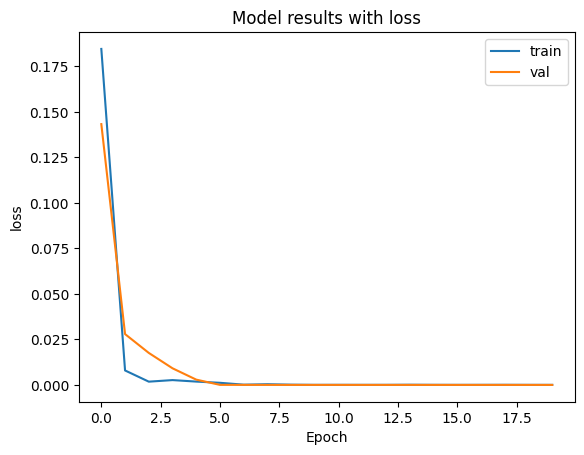

In [76]:
import matplotlib.pyplot as plt

def plot_metric(history, name):
  plt.title(f"Model results with {name}")
  plt.plot(history[name], label='train')
  plt.plot(history['val_'+name], label='val')
  plt.xlabel('Epoch')
  plt.ylabel(name)
  plt.legend()


plot_metric(history, 'loss')

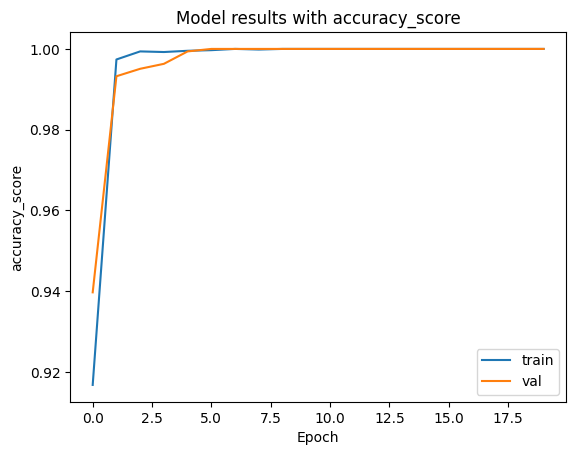

In [77]:
plot_metric(history, 'accuracy_score')

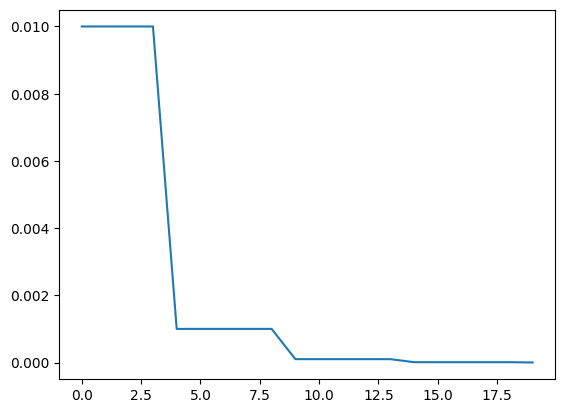

In [78]:
plt.plot(history['lr'])

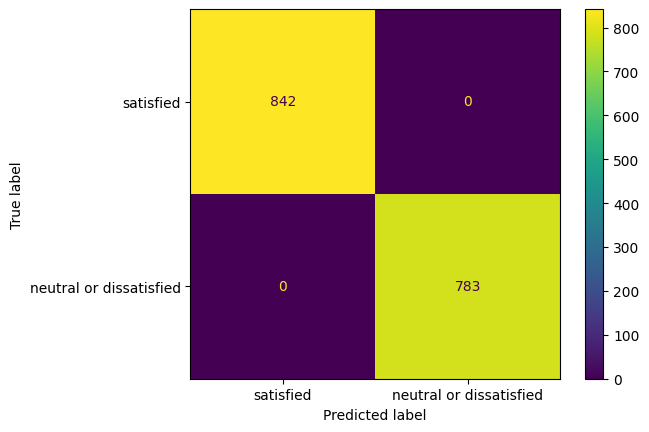

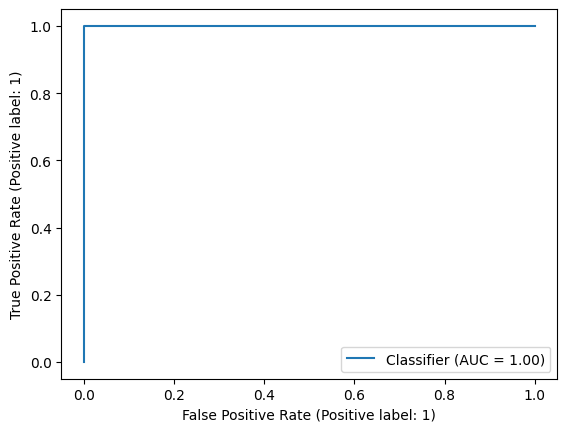

In [79]:

from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay

model = model.to('cpu')  
y_pred = model.predict(X_test)

ConfusionMatrixDisplay.from_predictions(y_test, y_pred.round(),
                                        display_labels=['satisfied', 'neutral or dissatisfied'])
plt.plot()

RocCurveDisplay.from_predictions(y_test, y_pred, pos_label=1)

In [81]:
# Збереження моделі
torch.save(model.state_dict(), 'mushroom_classifier.pth')


model.load_state_dict(torch.load('mushroom_classifier.pth'))


model.eval()
with torch.no_grad():
    predictions = model(torch.FloatTensor(X_test.values).to(device)).cpu().numpy()
    predictions = (predictions > 0.5).astype(int)